In [321]:
# import packages
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

from graphviz import Source

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# setting up figure parameters
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.figsize'] = (15.0/2, 20.0/2)

In [4]:
def GlobalMean(data, lat_ori, lon_ori):
    datanew = ma.masked_array(data, np.isnan(data))
    
    # calculate weights
    rr = np.deg2rad(6371220.0) # the number is Earth's radius

    dlon = np.abs(lon_ori[2] - lon_ori[1])*rr
    dx = dlon*np.cos(np.deg2rad(lat_ori))

    dy = np.empty(len(lat_ori))
    dy[:] = np.nan

    dy[0] = np.abs(lat_ori[2] - lat_ori[1])*rr
    dy[1:-1] = np.abs(lat_ori[2::] - lat_ori[0:-2])*rr*0.5
    dy[-1] = np.abs(lat_ori[-1] - lat_ori[-2])*rr

    area = dx*dy
    weight = np.broadcast_to(area, (len(lon_ori), len(lat_ori))).T
    
    # calculate weighted average
    result = []
    if data.ndim > 2:
        for i in np.arange(0, len(data)):
            tmp = ma.average(datanew[i,:,:], weights=weight)
            result.append(tmp)
    else:
        tmp = ma.average(datanew, weights=weight)
        result.append(tmp)
        
    return result

# Data preparation

In [157]:
# read in data
ORAp_t = 'sosstsst_control_regrid_monthly_3D_195801-201412.nc'
ORAp_h = 'sossheig_control_regrid_monthly_3D_195801-201412.nc'
ORAp_s = 'sosaline_control_regrid_monthly_3D_195801-201412.nc'
ORAp_m = 'somxl030_control_regrid_monthly_3D_195801-201412.nc'

ORA_SST = nc.Dataset(ORAp_t).variables['sst'][:]
ORA_SSH = nc.Dataset(ORAp_h).variables['ssh'][:]
ORA_SSS = nc.Dataset(ORAp_s).variables['sss'][:]
ORA_MLD = nc.Dataset(ORAp_m).variables['mxl'][:]

monthofYear = np.arange(1, np.shape(ORA_SST)[0]+1)
 
lat = nc.Dataset(ORAp_t).variables['lat'][:] #all nc files are regridded to same latlon values
lon = nc.Dataset(ORAp_t).variables['lon'][:]

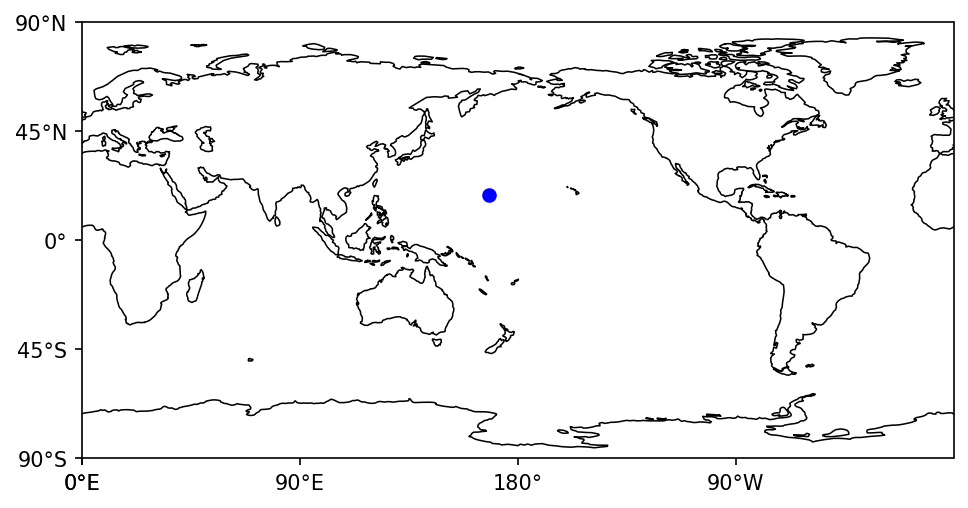

In [141]:
# pick a grid point
ilat = 90
ilon = 140

if ma.is_masked(ORA_SST[:,ilat,ilon]):
    print('Land! Try to pick a ocean grid :D')
else:
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(linewidth=.75)
    ax.set_global()

    ax.set_xticks([0, 90, 180, 270, 360], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.plot(lon[ilon], lat[ilat], 'ob', transform=ccrs.PlateCarree())
    
    plt.show()

# calculate climatology
OSST_c = np.nanmean(np.array(ORA_SST[:,ilat,ilon]).reshape((int(len(ORA_SST[:,ilat,ilon])/12), 12)), axis=0)
OSSH_c = np.nanmean(np.array(ORA_SSH[:,ilat,ilon]).reshape((int(len(ORA_SSH[:,ilat,ilon])/12), 12)), axis=0)
OSSS_c = np.nanmean(np.array(ORA_SSS[:,ilat,ilon]).reshape((int(len(ORA_SSS[:,ilat,ilon])/12), 12)), axis=0)
OMLD_c = np.nanmean(np.array(ORA_MLD[:,ilat,ilon]).reshape((int(len(ORA_MLD[:,ilat,ilon])/12), 12)), axis=0)
OSST_cf = np.tile(OSST_c, int(len(ORA_SST[:,ilat,ilon])/12))
OSSH_cf = np.tile(OSSH_c, int(len(ORA_SSH[:,ilat,ilon])/12))
OSSS_cf = np.tile(OSSS_c, int(len(ORA_SSS[:,ilat,ilon])/12))
OMLD_cf = np.tile(OMLD_c, int(len(ORA_MLD[:,ilat,ilon])/12))

# remove climatology (just for predictors)
OSST_a = ORA_SST[:,ilat,ilon] - OSST_cf
OSSH_a = ORA_SSH[:,ilat,ilon] - OSSH_cf
OSSS_a = ORA_SSS[:,ilat,ilon] - OSSS_cf

# calculate global-mean
# Osst_GM = GlobalMean(ORA_SST, lat, lon)
# Ossh_GM = GlobalMean(ORA_SSH, lat, lon)
# Osss_GM = GlobalMean(ORA_SSS, lat, lon)
# Omld_GM = GlobalMean(ORA_MLD, lat, lon)

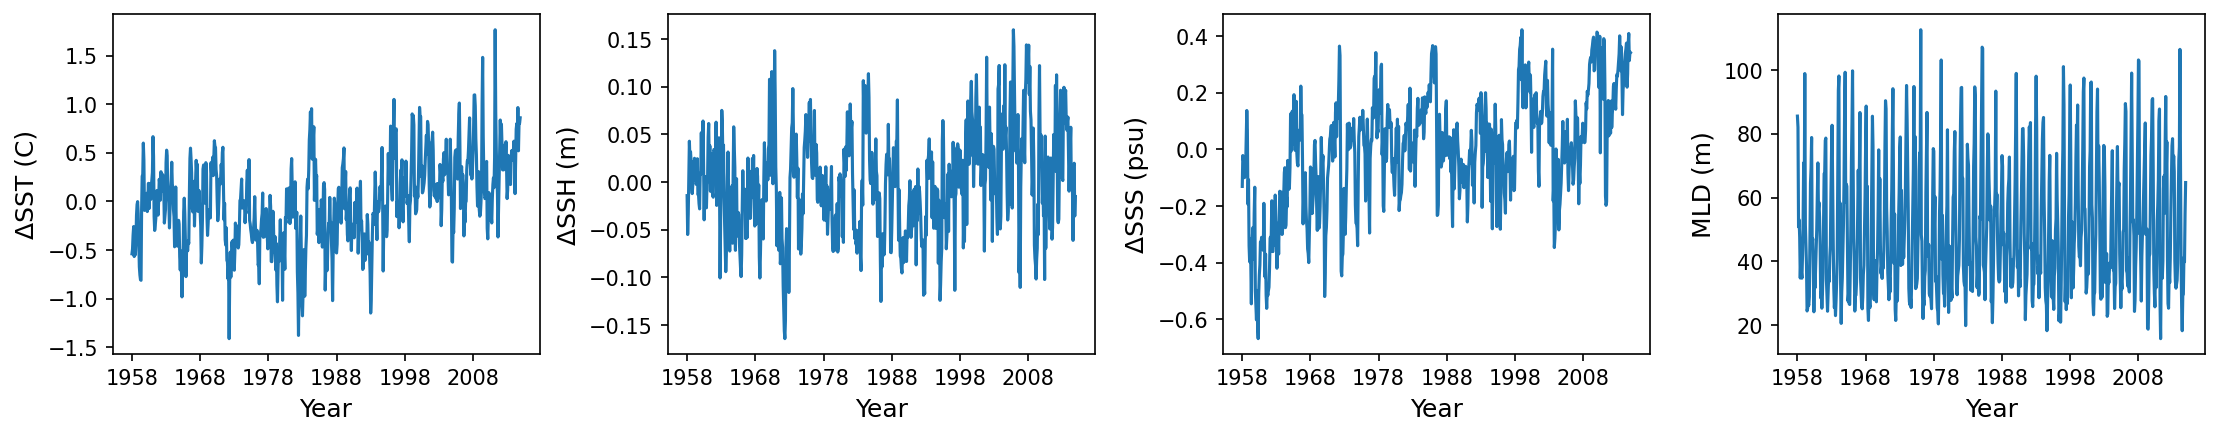

In [142]:
# visualize the timeseries
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_xlabel('Year')
    axs[j].set_xticks(np.arange(0,len(ORA_SST[:,ilat,ilon]),120), np.arange(1958,2014,10))

axs[0].set_ylabel('\u0394SST (C)')
axs[1].set_ylabel('\u0394SSH (m)')
axs[2].set_ylabel('\u0394SSS (psu)')
axs[3].set_ylabel('MLD (m)')

axs[0].plot(OSST_a)
axs[1].plot(OSSH_a)
axs[2].plot(OSSS_a)
axs[3].plot(ORA_MLD[:,ilat,ilon])
        
fig.subplots_adjust(wspace=0.3)

# plt.savefig('./storyline/Fig3.pdf', bbox_inches='tight')
plt.show()

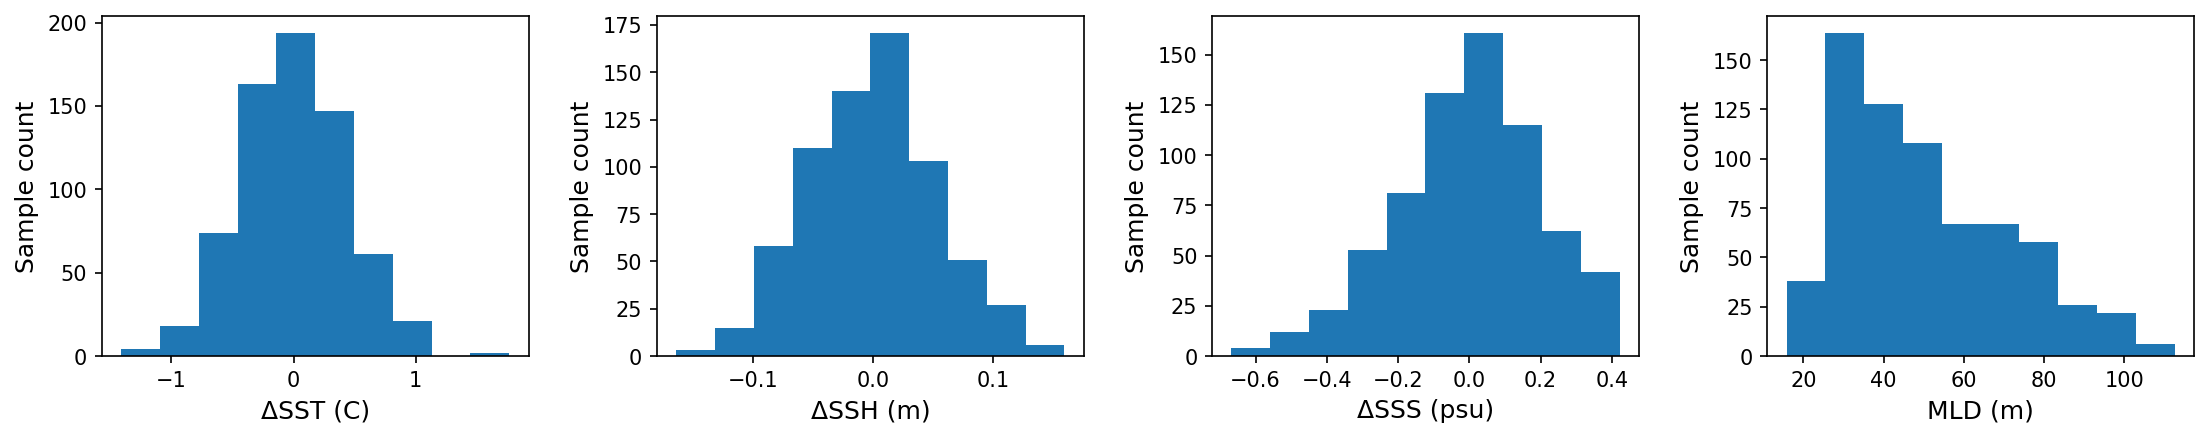

In [143]:
# check timeseries distribution
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(18,3))
gs = gridspec.GridSpec(1, 4, figure=fig)

for j in np.arange(0,4):
    axs[j] = plt.subplot(gs[j])
    axs[j].set_ylabel('Sample count')

axs[0].set_xlabel('\u0394SST (C)')
axs[1].set_xlabel('\u0394SSH (m)')
axs[2].set_xlabel('\u0394SSS (psu)')
axs[3].set_xlabel('MLD (m)')

axs[0].hist(OSST_a)
axs[1].hist(OSSH_a)
axs[2].hist(OSSS_a)
axs[3].hist(ORA_MLD[:,ilat,ilon])
        
fig.subplots_adjust(wspace=0.3)
plt.show()

In [158]:
# predictors and predictand
X = np.empty((len(OSST_a), 7))
X[:,:] = np.nan

X[:,0] = monthofYear
X[:,1] = OSST_cf
X[:,2] = OSSH_cf
X[:,3] = OSSS_cf
X[:,4] = OSST_a
X[:,5] = OSSH_a
X[:,6] = OSSS_a

y = np.copy(ORA_MLD[:,ilat,ilon])

label_names = ['MLD']
feature_list = ['month of year', 'SST - climatology', 'SSH - climatology', 'SSS - climatology', 'SST - anomaly', 'SSH - anomaly', 'SSS - anomaly']

# Train/test set

In [159]:
# spliting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # how to do no-shuffle?

# # doesn't seem necessary to do standardization for a random tree model
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Training Features Shape: (513, 7)
Testing Features Shape: (171, 7)


# Built a decision tree model to predict MLD by using surface variables

In [473]:
# Train the model

# parameters that intentinally overfit the data
tree_depth = 15
node_split = 2  # minimum number of training samples needed to split a node
leaf_samples = 1  # minimum number of training samples required to make a leaf node
RAND_STATE = 128

tree_clf = DecisionTreeRegressor(max_depth=tree_depth,
                                 min_samples_split=node_split,
                                 min_samples_leaf=leaf_samples,
                                 random_state=RAND_STATE,
                                 criterion="squared_error")  # 'gini' for classifier

tree_clf.fit(X_train, y_train)
# tree_clf.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=15, random_state=128)

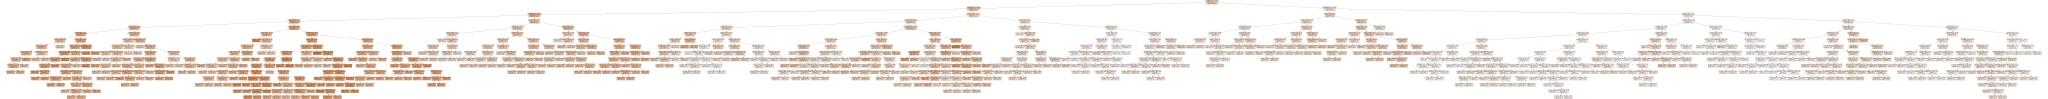

In [474]:
# visualize how the tree looks like
fig_savename = "MLD_regressor"

if len(np.shape(tree_clf)) != 0:
    tree_to_viz = tree_clf[0]  # this line sets which decision tree out of your RF you want to plot
else:
    tree_to_viz = tree_clf
    
export_graphviz(tree_to_viz,
                out_file='./' + fig_savename + ".dot",
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=label_names,
                feature_names=feature_list)

Source.from_file('./' + fig_savename + ".dot")

## Importance of each feature

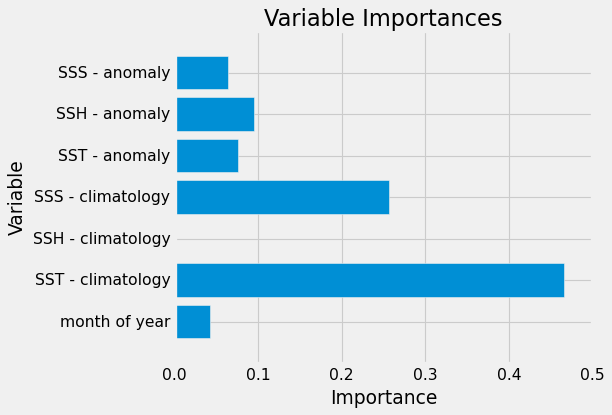

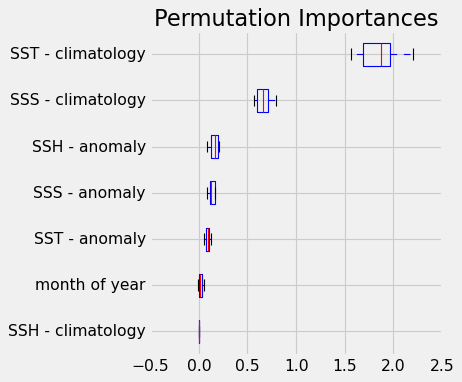

In [475]:
# Impurity importance
importances = list(tree_clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Single-pass permutation
permute = permutation_importance(tree_clf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = permute.importances_mean.argsort()

new_feature_list = []
for index in sorted_idx:  
    new_feature_list.append(feature_list[index])

plt.figure(figsize=(6,5))
plt.style.use('fivethirtyeight')
plt.barh(list(range(len(importances))), importances)
plt.yticks(list(range(len(importances))), feature_list)
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(permute.importances[sorted_idx].T, vert=False, labels=new_feature_list)
ax.set_title("Permutation Importances")
fig.tight_layout()

## Make a prediction

In [476]:
y_pred_train = tree_clf.predict(X_train)
y_pred_test = tree_clf.predict(X_test)

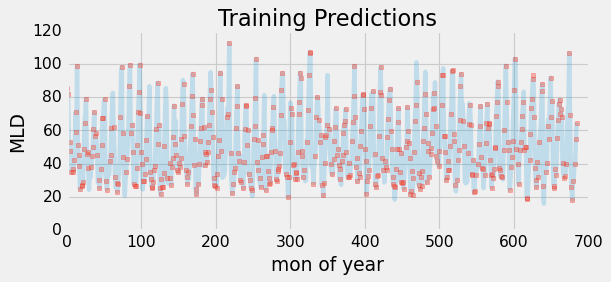

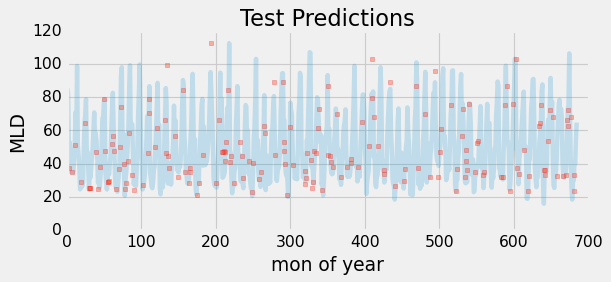

In [477]:
# visualize the predictions
for split_type in ("Training", "Test"):
    if split_type == "Training":
        plot_features = X_train
        plot_pred = y_pred_train
    elif split_type == "Test":
        plot_features = X_test
        plot_pred = y_pred_test
    else:
        raise NotImplementedError()

    fig, ax = plt.subplots(figsize=(7.5, 3))

    ax.plot(X[:,0], ORA_MLD[:,ilat,ilon], alpha=0.2)
    ax.plot(plot_features[:,0], plot_pred, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
    ax.set_xlabel("mon of year")
    ax.set_ylabel("MLD")

    plt.title(split_type + " Predictions")
    plt.show()

## Evaluate decision tree model

In [478]:
# calculate MLD climatology for evaluation
baseline = np.copy(OMLD_cf)

# Baseline errors (mean absolute errors)
mae_baseline_errors = abs(baseline - y)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))

# Baseline errors (mean squared errors)
mse_baseline_errors = np.sqrt(np.mean((baseline - y)**2))
print('Baseline error (MSE): ', round(mse_baseline_errors, 2))

Baseline error (MAE):  7.9
Baseline error (MSE):  10.42


In [479]:
# Model errors (mean absolute errors)
mae_model_errors = abs(y_pred_test - y_test)
print('Model error (MAE): ', round(np.mean(mae_model_errors), 2))

# Model errors (mean squared errors)
mse_model_errors = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Model error (MSE): ', round(mse_model_errors, 2))

Model error (MAE):  8.46
Model error (MSE):  11.33


# Build a random forest model for the same problem

In [480]:
# train the model

# intentially overfit the model
number_of_trees = 10
tree_depth = None 
node_split = 2
leaf_samples = 1
criterion = 'mae'    # variance reduction, alternatively 'mae'
RAND_STATE = 128

rf = RandomForestRegressor(n_estimators = number_of_trees, 
                           random_state = RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           criterion = criterion,
                           max_depth = tree_depth)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', n_estimators=10, random_state=128)

## make predictions and evaluate model performance

In [481]:
y_rf_pred_train = rf.predict(X_train)
y_rf_pred_test = rf.predict(X_test)

mae_rf_errors = abs(y_rf_pred_test - y_test)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Model error (MAE): ', round(np.mean(mae_rf_errors), 2))

# Model errors (mean squared errors)
mse_rf_errors = np.sqrt(np.mean((y_rf_pred_test - y_test)**2))
print('Baseline error (MSE): ', round(mse_baseline_errors, 2))
print('Model error (MSE): ', round(mse_rf_errors, 2))

Baseline error (MAE):  7.9
Model error (MAE):  6.92
Baseline error (MSE):  10.42
Model error (MSE):  9.39


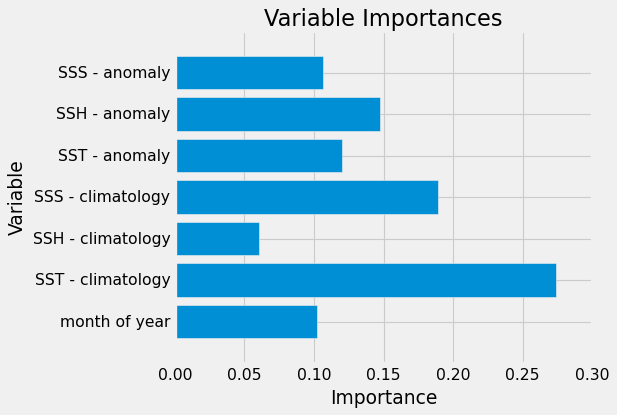

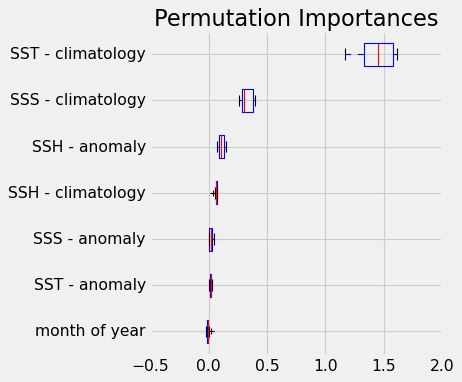

In [482]:
# Impurity importance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Single-pass permutation
permute = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = permute.importances_mean.argsort()

new_feature_list = []
for index in sorted_idx:  
    new_feature_list.append(feature_list[index])

plt.figure(figsize=(6,5))
plt.style.use('fivethirtyeight')
plt.barh(list(range(len(importances))), importances)
plt.yticks(list(range(len(importances))), feature_list)
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(permute.importances[sorted_idx].T, vert=False, labels=new_feature_list)
ax.set_title("Permutation Importances")
fig.tight_layout()

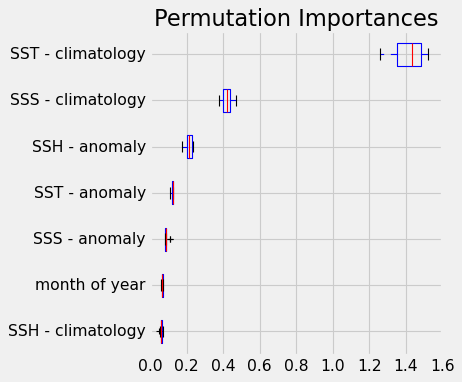

In [483]:
# Permutation importances in training dataset
permute = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = permute.importances_mean.argsort()

new_feature_list = []
for index in sorted_idx:  
    new_feature_list.append(feature_list[index])

fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(permute.importances[sorted_idx].T, vert=False, labels=new_feature_list)
ax.set_title("Permutation Importances")
fig.tight_layout()

## visualize model predictions

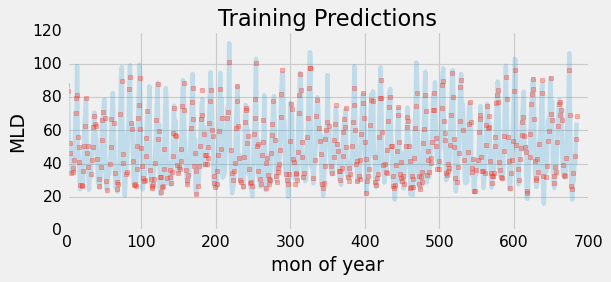

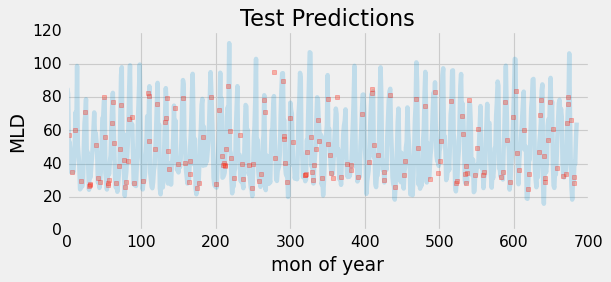

In [484]:
# visualize the predictions
for split_type in ("Training", "Test"):
    if split_type == "Training":
        plot_features = X_train
        plot_pred = y_rf_pred_train
    elif split_type == "Test":
        plot_features = X_test
        plot_pred = y_rf_pred_test
    else:
        raise NotImplementedError()

    fig, ax = plt.subplots(figsize=(7.5, 3))

    ax.plot(X[:,0], ORA_MLD[:,ilat,ilon], alpha=0.2)
    ax.plot(plot_features[:,0], plot_pred, "s", markersize=3, alpha=0.4, linewidth=0.1, markeredgecolor="r")
    ax.set_xlabel("mon of year")
    ax.set_ylabel("MLD")

    plt.title(split_type + " Predictions")
    plt.show()